In [1]:
import json
import matplotlib.pyplot as plt
from arsenic import stats
import networkx as nx

In [2]:
results = json.load(open('2020-08-20-benzotriazoles/analysis.json','r'))

In [67]:
graphs = {}

# one graph per PROTEIN, however different ligand files will all end up in the same graph.
# this might result in unconnected graphs but we will handle that later
# also, maybe there's a magic way to weight the free energy to two different protein files, but I don't know what that is
for result in results:
    protein = result['details']['protein']
    ligand = result['details']['ligand']
    if protein not in graphs:
        graphs[protein] = nx.DiGraph()
#     if (protein, ligand) not in graphs:
#         graphs[(protein,ligand)] = nx.DiGraph()

In [68]:
# there's only one protein used in sprint 3

print(f'{len(graphs)} protein graphs')

1 protein graphs


In [56]:
# now loop through all the results, and add an edge with a free energy and uncertainty
# arsenic is fussy --- it likes f_ij and f_dij, but I can change arsenic in future to be more flexible

for result in results:
    protein = result['details']['protein']
    ligand = result['details']['ligand']
#     graph = graphs[(protein,ligand)]
    graph = graphs[protein]
    if result['analysis']['binding']['delta_f'] is not None and result['analysis']['binding']['ddelta_f'] is not None:
        graph.add_edge(result['details']['start_smiles'], result['details']['end_smiles'],f_ij=result['analysis']['binding']['delta_f'],f_dij=result['analysis']['binding']['ddelta_f'])


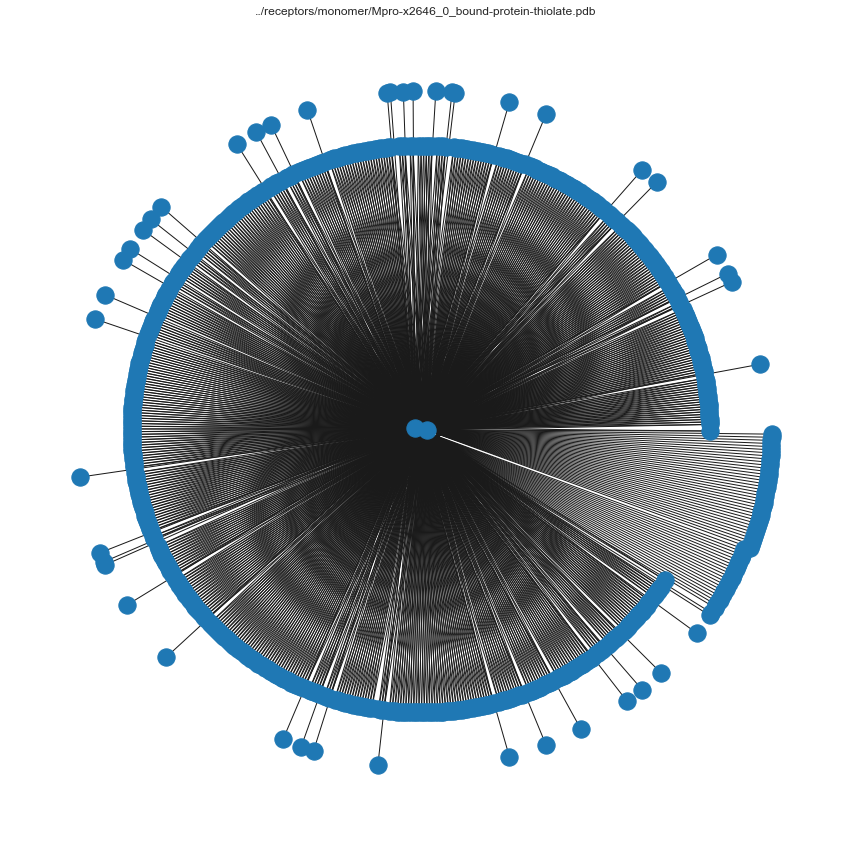

In [57]:
for title, graph in graphs.items():
    plt.figure(figsize=(15,15))
    plt.title(title)
    # this should pull the more connected elements of the graph closer to the center
    nx.draw_kamada_kawai(graph)
    plt.show()

In [58]:
# need to check that the graph is weakly connected or not. If not, will need to break up into subsets of weakly connected graphs

# if not nx.is_weakly_connected(graph):
    ### need to write some code doing this each time for something like
    # for subgraph in nx.weakly_connected_components(graph): 
    # etc...

In [64]:
# now add any experimental values that we might have
for result in results:
    for state in ['start','end']:
        if f'{state}_pIC50' in result['details'].keys():
            for graph in graphs.values():
                if graph.has_node(result['details'][f'{state}_smiles']):
                    # see if it already has an pIC50
                    if 'pIC50' in graph.nodes[result['details'][f'{state}_smiles']]:
                        assert(result['details'][f'{state}_pIC50'] == graph.nodes[result['details'][f'{state}_smiles']]['pIC50']), \
                        f"Trying to add an pIC50 that disagrees with a previous value for node {graph.nodes[result['details'][f'{state}_smiles']]}"
                    else:
                        # or add the pIC50 if it's not available
                        graph.nodes[result['details'][f'{state}_smiles']]['pIC50'] = result['details'][f'{state}_pIC50']    

                        
# these should be defined in a different way, but at the moment, this will do   
# just whatever we want to compare everything against, presumably anything with an experimental datapoint
centers = []                   
for node in graph.nodes(data=True):
    if len(node[1]) > 0:
        print(node)
        centers.append(node[0])

('CN(C)c1ccc(cc1)N(Cc2ccsc2)C(=O)Cn3c4ccccc4nn3', {'pIC50': '5.74624419353312'})
('CCC(=O)Nc1ccc(cc1)N(Cc2ccsc2)C(=O)Cn3c4ccccc4nn3', {'pIC50': '5.78844242195303'})


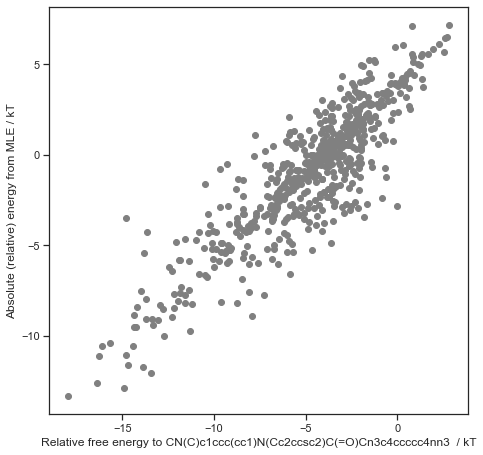

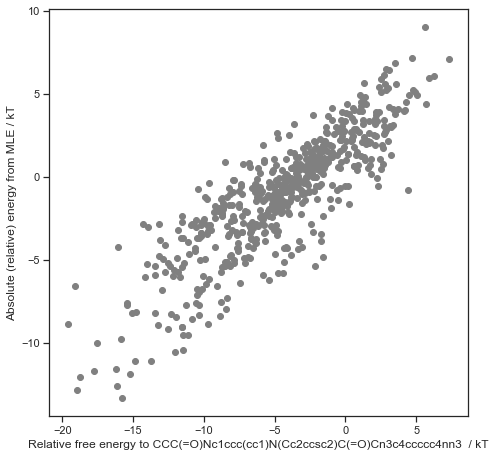

In [65]:
# center = 'CCC(=O)Nc1ccc(cc1)N(Cc2ccsc2)C(=O)Cn3c4ccccc4nn3'

for graph in graphs.values():
    f_i, C = stats.mle(graph)
    
    for center in centers:
        plt.figure(figsize=(7.5,7.5))
        for i,j, err in zip(f_i, graph.nodes(),np.diag(C)):
            try:
                # HBM --- not sure why the sign of this gets flipped???
                # TODO - shift these corresponding to pIC50 of center, so that we have absolute absolutes
                plt.scatter(-graph.get_edge_data(j, center)['f_ij'], i ,color='grey')
            except TypeError:
                continue

        plt.ylabel('Absolute (relative) energy from MLE / kT')
        plt.xlabel(f'Relative free energy to {center}  / kT')
        plt.show()